# Import Libraries

In [92]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics   

# Import Data from CSV

In [185]:
df = pd.read_csv('takehome_users.csv', encoding='latin-1')
print(len(df))
df.head()

12000


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [186]:
usage = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')
usage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [187]:
usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


# Identify 'Adopted Users'

In [188]:
def convertToDate(dt):
    #print(type(dt))
    return dt.date()

usage['time_stamp'] = pd.to_datetime(usage['time_stamp']).apply(convertToDate)
usage['time_stamp'] = pd.to_datetime(usage['time_stamp'])
#usage.info()
usage.head()

,time_stamp,user_id,visited
0,2014-04-22,1,1
1,2013-11-15,2,1
2,2013-11-29,2,1
3,2013-12-09,2,1
4,2013-12-25,2,1


In [189]:
userIds = usage['user_id'].unique().tolist()
len(userIds)

8823

In [190]:
adoptedUsersList = []
for uid in tqdm(userIds):
    #print(uid)
    userdf = usage[usage['user_id']==uid]
    #userdf['time_stamp'] = userdf['time_stamp'].date()
    gdf = userdf.groupby('user_id')['time_stamp'].apply(list)
    #print(gdf)
    login_logs = gdf.values.tolist()[0]
    temp1 = login_logs[0]
    temp2 = 0
    temp3 = 0
    buffer = timedelta(days= 7)
    for t in login_logs[1:]:
        if temp2 == 0:
            temp2 =t
        else:
            temp3 =t
            if temp3 - temp1 < buffer:
                adoptedUsersList.append(uid)
                break
            temp1 = temp2
            temp2 = temp3
            
len(adoptedUsersList)

100%|█████████████████████████████████████████████████████████████████████████████| 8823/8823 [00:22<00:00, 384.61it/s]


1602

In [191]:
df['adoptedUser'] = 0
df.loc[df['object_id'].isin(adoptedUsersList), 'adoptedUser'] = 1
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adoptedUser
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [192]:
df['adoptedUser'].value_counts()

0    10398
1     1602
Name: adoptedUser, dtype: int64

## LabelEncode creation_source

In [193]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 
  
df['creation_source_encoded'] = le.fit_transform(df['creation_source'])

In [194]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adoptedUser,creation_source_encoded
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,0


## Find feature correlations

In [195]:
df.corr()['adoptedUser']

object_id                     0.005750
last_session_creation_time    0.396550
opted_in_to_mailing_list      0.008097
enabled_for_marketing_drip    0.004653
org_id                        0.064523
invited_by_user_id            0.000675
adoptedUser                   1.000000
creation_source_encoded      -0.003659
Name: adoptedUser, dtype: float64

([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

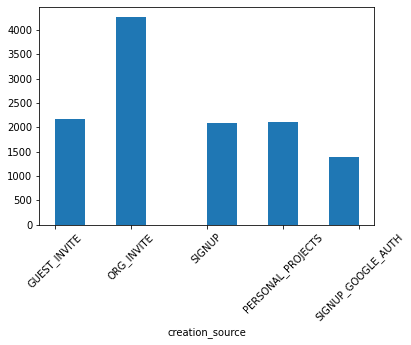

In [196]:
plt.hist(df['creation_source'])
plt.xlabel('creation_source')
plt.xticks(rotation=45)

## Building a Model - Random Forest Classifier

ohotdf = pd.DataFrame(onehotlabels, columns=enc.get_feature_names(['creation_source_encoded']).tolist())

df['org_id'].nunique()

X_3 = df[['org_id']]
enc.fit(X_3)
onehotlabels = enc.transform(X_3).toarray()
ohotdf2 = pd.DataFrame(onehotlabels, columns=enc.get_feature_names(['org_id']).tolist())
ohotdf2.head()

mod = pd.concat([df, ohotdf, ohotdf2], axis=1).drop(columns=['object_id', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'creation_source_encoded'])
mod.head()

In [197]:
df2 = df[['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'adoptedUser', 'creation_source_encoded']]
df2 = df2.astype('category', copy=True)
df2.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adoptedUser,creation_source_encoded
0,1,0,11,0,0
1,0,0,1,1,1
2,0,0,94,0,1
3,0,0,1,0,0
4,0,0,193,0,0


In [198]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   opted_in_to_mailing_list    12000 non-null  category
 1   enabled_for_marketing_drip  12000 non-null  category
 2   org_id                      12000 non-null  category
 3   adoptedUser                 12000 non-null  category
 4   creation_source_encoded     12000 non-null  category
dtypes: category(5)
memory usage: 94.2 KB


In [199]:
X = df2.drop(columns=['adoptedUser'])
y = df2[['adoptedUser']]

X = mod.drop(columns=['adoptedUser', 'creation_time', 'org_id', 'invited_by_user_id']).values
y = mod[['adoptedUser']].values

### Train - test split

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8040, 4), (3960, 4), (8040, 1), (3960, 1))

In [202]:
clf = RandomForestClassifier(n_estimators = 100, max_depth=5, bootstrap = True)   
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test) 
print(y_pred.shape) 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

C:\Users\iamku\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


(3960,)
ACCURACY OF THE MODEL:  0.8646464646464647


### The accuracy of our Random Forest model is 86.46% which is good enough to work with.
###  We can now identify the predictive power of each feature

## Get feature importance from the trained model

In [203]:
importance = clf.feature_importances_
importance = pd.DataFrame(importance, columns=['importance'])
importance.index = X.columns
importance

,importance
opted_in_to_mailing_list,0.050091
enabled_for_marketing_drip,0.051215
org_id,0.643792
creation_source_encoded,0.254901


## Conclusion: Most import factor for predicting adopted user is ORGANIZATION ID, followed by CREATION SOURCE

In [184]:
pd.DataFrame(df2[df2['adoptedUser']==1]['org_id'].value_counts()).rename(columns={'org_id':'freq'})

,freq
4,16
7,16
2,15
9,14
13,14
...,...
151,0
279,0
362,0
365,0
